In [1]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"

opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [2]:
!rm -rf /kaggle/working/results/checkpoint-*
!rm -rf /kaggle/working/logs/*


In [3]:
!pip install torch torchvision transformers opencv-python scikit-learn

In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [5]:
# Define the transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms
from PIL import Image
import os

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")

# Verify column names
print(df.columns)

# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [7]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, images_folder, image_transforms):
        # Filter out 'non informative' rows
        self.dataframe = dataframe[dataframe['label'].str.lower().str.strip() != 'non informative'].reset_index(drop=True)
        self.images_folder = images_folder
        self.image_transforms = image_transforms

        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'anthropogenic': 4
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['label']
        image_id = str(row[' id']).strip()  # Adjust key if needed

        # Convert string label to int
        if isinstance(label, str):
            label = self.class_to_index[label.lower().strip()]
        else:
            label = int(label)

        # Check file extensions
        image_path_jpg = os.path.join(self.images_folder, f"{image_id}.jpg")
        image_path_png = os.path.join(self.images_folder, f"{image_id}.png")
        image_path_jpeg = os.path.join(self.images_folder, f"{image_id}.jpeg")

        if os.path.exists(image_path_jpg):
            image_path = image_path_jpg
        elif os.path.exists(image_path_png):
            image_path = image_path_png
        elif os.path.exists(image_path_jpeg):
            image_path = image_path_jpeg
        else:
            raise FileNotFoundError(f"Image {image_id} not found with .jpg, .png or .jpeg extension")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)

        assert 0 <= label <= 4, f"Label {label} out of range"

        return {
            'original_label': label,
            'pixel_values': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

# Utility to show image
def imshow(image, ax=None, title=None, normalize=False):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax

# Utility to print samples
def print_samples(dataloader, num_samples=5):
    count = 0
    for batch in dataloader:
        if count >= num_samples:
            break
        for i in range(len(batch['pixel_values'])):
            if count >= num_samples:
                break
            print(f"Sample {count+1}:")
            print(f"Original Label: {batch['original_label'][i]}")
            imshow(batch['pixel_values'][i], normalize=True)
            plt.show()
            print()
            count += 1

In [8]:
# Data augmentation and normalization transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [9]:
# Paths
images_folder = '/kaggle/input/mddb-images/Photos_Final'

# Dataset and loaders (make sure train_data, valid_data, test_data DataFrames exist)
train_dataset = ImageDataset(train_data, images_folder, train_transforms)
valid_dataset = ImageDataset(valid_data, images_folder, valid_transforms)
test_dataset = ImageDataset(test_data, images_folder, valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [14]:
import torch.nn as nn
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Model setup: Load Pretrained ViT Model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=5)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer and criterion
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2)  # Learning rate scheduler

# Preprocessing for ViT (using ViTImageProcessor)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Data augmentation transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training function
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for batch in data_loader:
        optimizer.zero_grad()
        inputs = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through ViT
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

# Validation function
def validate_one_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)

            # Forward pass through ViT
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

# Early stopping parameters
num_epochs = 20  # Increased epochs for better training
best_acc = 0.0
patience = 5  # Increased patience for early stopping
counter = 0

# Lists to save loss and accuracy for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate_one_epoch(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc.item())
    valid_accuracies.append(valid_acc.item())

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    scheduler.step(valid_loss)  # Step the scheduler after validation loss

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
        print(f'Validation accuracy improved to {best_acc:.4f}. Model saved.')
    else:
        counter += 1
        print(f'No improvement for {counter} epoch(s)')

    if counter >= patience:
        print(f'Early stopping triggered after {patience} epochs with no improvement.')
        break

print('Training complete')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
Train Loss: 1.5266 | Train Acc: 0.3848
Valid Loss: 1.4110 | Valid Acc: 0.6245
Validation accuracy improved to 0.6245. Model saved.
Epoch 2/20
Train Loss: 1.3065 | Train Acc: 0.6215
Valid Loss: 1.1692 | Valid Acc: 0.6877
Validation accuracy improved to 0.6877. Model saved.
Epoch 3/20
Train Loss: 1.0936 | Train Acc: 0.6549
Valid Loss: 0.9755 | Valid Acc: 0.7212
Validation accuracy improved to 0.7212. Model saved.
Epoch 4/20
Train Loss: 0.9374 | Train Acc: 0.7047
Valid Loss: 0.8583 | Valid Acc: 0.7342
Validation accuracy improved to 0.7342. Model saved.
Epoch 5/20
Train Loss: 0.8662 | Train Acc: 0.7116
Valid Loss: 0.8011 | Valid Acc: 0.7379
Validation accuracy improved to 0.7379. Model saved.
Epoch 6/20
Train Loss: 0.7542 | Train Acc: 0.7550
Valid Loss: 0.7379 | Valid Acc: 0.7621
Validation accuracy improved to 0.7621. Model saved.
Epoch 7/20
Train Loss: 0.6886 | Train Acc: 0.7859
Valid Loss: 0.7053 | Valid Acc: 0.7825
Validation accuracy improved to 0.7825. Model saved.
Epoch 

In [12]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Predictions function
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['pixel_values'].to(device)
            outputs = model(inputs).logits  # Correct extraction of logits
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs).logits  # Correct extraction of logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds)

    return accuracy, precision, recall, f1, report, all_labels, all_preds

# Testing the model
accuracy, precision, recall, f1, report, all_labels, all_preds = evaluate_model(model, test_loader, device)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(report)

<ipython-input-12-8ab03d2ab1fe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 0.7682
Precision: 0.7700
Recall: 0.7682
F1 Score: 0.7677

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       106
           1       0.67      0.61      0.64       101
           2       0.68      0.78      0.73        89
           3       0.77      0.79      0.78        97
           4       0.85      0.77      0.81       142

    accuracy                           0.77       535
   macro avg       0.76      0.77      0.76       535
weighted avg       0.77      0.77      0.77       535



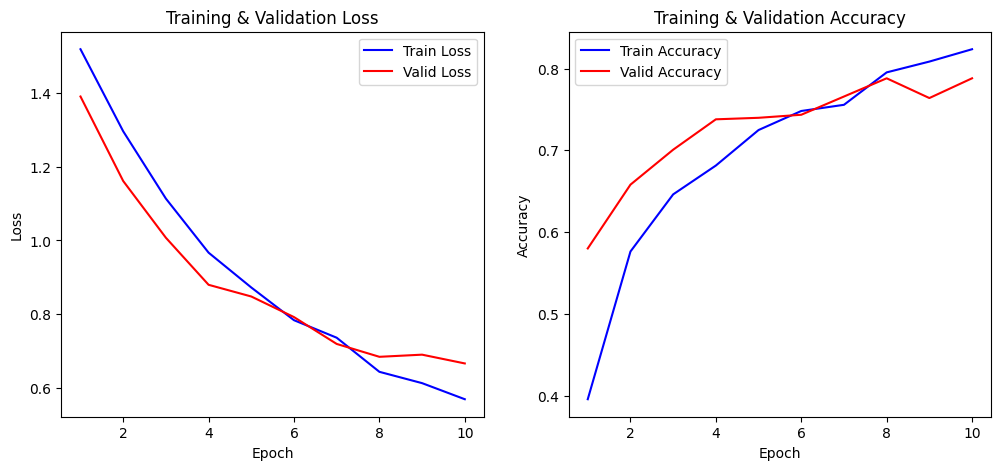

In [13]:
# Plot training & validation loss and accuracy curves
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, valid_losses, 'r-', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'r-', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()